In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import utils
import visualization
from consts import *



In [4]:
def read_file(file):
    dataframe = pd.read_csv(file)
    if dataframe.empty:
        dataframe = pd.DataFrame(np.nan, index=[0], columns=dataframe.columns)

    filename = os.path.basename(file)
    dataframe[FILENAME] = filename
    dataframe[SOURCE] = utils.parse_filename(filename)[1]

    return dataframe

In [5]:
files_paths = [str(file_path) for file_path in DATA_DIR.joinpath(DATA_DIR, "real_production_input").glob("*.csv")]
files_paths.sort()

cumulative_production = pd.concat(map(read_file, files_paths), ignore_index=True)

In [6]:
cumulative_production

,time,source,device_name,fragment.series,value,unit,filename
0,NaN,540121820,NaN,NaN,NaN,NaN,data_540121820_2020-01-01_2020-01-31.csv
1,NaN,540121820,NaN,NaN,NaN,NaN,data_540121820_2020-02-01_2020-02-29.csv
2,NaN,540121820,NaN,NaN,NaN,NaN,data_540121820_2020-03-01_2020-03-31.csv
3,NaN,540121820,NaN,NaN,NaN,NaN,data_540121820_2020-04-01_2020-04-30.csv
4,NaN,540121820,NaN,NaN,NaN,NaN,data_540121820_2020-05-01_2020-05-31.csv
...,...,...,...,...,...,...,...
847733,2022-12-08T15:21:51.983Z,547239708,Päikeseenergia,dal.series,44765.2,kWh,data_547239708_2022-12-01_2022-12-31.csv
847734,2022-12-09T06:55:19.626Z,547239708,Päikeseenergia,dal.series,44765.2,kWh,data_547239708_2022-12-01_2022-12-31.csv
847735,2022-12-09T07:17:19.057Z,547239708,Päikeseenergia,dal.series,44765.2,kWh,data_547239708_2022-12-01_2022-12-31.csv
847736,2022-12-09T13:33:20.713Z,547239708,Päikeseenergia,dal.series,44765.2,kWh,data_547239708_2022-12-01_2022-12-31.csv


In [7]:
get_year_vectorized = np.vectorize(utils.get_year, excluded="index")

In [8]:
get_month_vectorized = np.vectorize(utils.get_month, excluded="index")

In [9]:
cumulative_production.drop(columns=["device_name", "fragment.series", "unit"], inplace=True)
cumulative_production.rename(columns={"value": VALUE_KWH}, inplace=True)
cumulative_production[YEAR] = get_year_vectorized(cumulative_production.filename, 2)
cumulative_production[MONTH] = get_month_vectorized(cumulative_production.filename, 2)

In [10]:
files_numbers = cumulative_production[[FILENAME, YEAR]].drop_duplicates()[YEAR].value_counts()
files_numbers

year
2020    204
2021    204
2022    204
Name: count, dtype: int64

### Empty files

In [11]:
empty_files_numbers = cumulative_production[cumulative_production["time"].isna()][YEAR].value_counts()
empty_files_numbers

year
2020    171
2021     44
2022     34
Name: count, dtype: int64

In [12]:
years = empty_files_numbers.index.to_list()
for year in years:
    print(f"{empty_files_numbers[year] / files_numbers[year] * 100:.2f}% of the files for {year} are empty.")

print(f"{empty_files_numbers.sum() / files_numbers.sum() * 100:.2f}% of the total number of files are empty.")

83.82% of the files for 2020 are empty.
21.57% of the files for 2021 are empty.
16.67% of the files for 2022 are empty.
40.69% of the total number of files are empty.


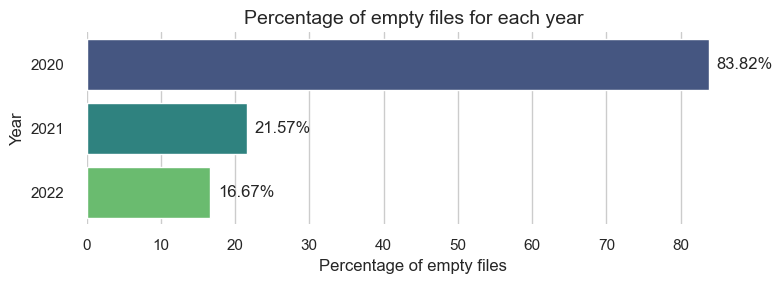

In [13]:
visualization.plot_empty_files_bar_graph(years, empty_files_numbers, files_numbers, 'Percentage of empty files for each year')

In [343]:
sources_number = cumulative_production[SOURCE].unique().size

In [344]:
sources_number

17

In [345]:
cumulative_production_nan_cleaned = cumulative_production.dropna()

In [346]:
cumulative_production_nan_cleaned[SOURCE].unique().size

16

In [347]:
buildings_df = pd.read_csv(DEVICES_MAPPED_PATH)
columns = buildings_df.columns.tolist()
columns = columns[-2:] + columns[:-2]
buildings_df = buildings_df[columns]
buildings_df.head(2)

,orientation,pv_area_m2,source,address,etak_id
0,south,172.34,540121820,Tiigi 19,719155
1,none,26.64,540121820,Tiigi 19,719155


In [348]:
buildings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   orientation  19 non-null     object 
 1   pv_area_m2   19 non-null     float64
 2   source       19 non-null     int64  
 3   address      19 non-null     object 
 4   etak_id      19 non-null     int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 888.0+ bytes


In [349]:
buildings_df = buildings_df.groupby([ETAK_ID, SOURCE, ADDRESS]).agg({PV_AREA_M2: "sum"})

In [350]:
buildings_df.reset_index(inplace=True)

In [351]:
buildings_df

,etak_id,source,address,pv_area_m2
0,713413,547236060,Turu 3,165.44
1,715116,547236058,Turu 9,147.85
2,716647,547236018,Tähe 2,182.69
3,716801,547236076,Tiigi 8,257.01
4,719155,540121820,Tiigi 19,198.98
5,719414,547236056,Pepleri 10,169.67
6,719935,547236070,Lutsu 16,187.23
7,720043,547236054,Aleksandri 3,146.65
8,720239,547236066,Pepleri 12,171.77
9,720448,547236068,J.Kuperjanovi 2,193.61


In [352]:
buildings_df[SOURCE] = buildings_df[SOURCE].astype(str)
buildings_df[ETAK_ID] = buildings_df[ETAK_ID].astype(str)

In [353]:
if sources_number - cumulative_production_nan_cleaned[SOURCE].unique().size != 0:
    no_data_sources = np.setdiff1d(cumulative_production[SOURCE].unique(), cumulative_production_nan_cleaned[SOURCE].unique())
    print("Sources with no data registered:")
    print(buildings_df[buildings_df[SOURCE].isin(no_data_sources)])

Sources with no data registered:
   etak_id     source    address  pv_area_m2
15  721071  547236064  Kalevi 10      128.24


In [354]:
non_empty_certain_year_data = cumulative_production_nan_cleaned[cumulative_production_nan_cleaned[YEAR] == empty_files_numbers.idxmax()]

In [355]:
non_empty_certain_year_data[[SOURCE, MONTH]].drop_duplicates()[MONTH].value_counts()

month
10    11
11    11
12    11
Name: count, dtype: int64

In [356]:
non_empty_certain_year_sources = non_empty_certain_year_data[SOURCE].unique()
print(f"Non-empty sources for the year with maximum number of empty files ({empty_files_numbers.idxmax()}):")
print(buildings_df[buildings_df[SOURCE].isin(non_empty_certain_year_sources)])

Non-empty sources for the year with maximum number of empty files (2020):
   etak_id     source          address  pv_area_m2
0   713413  547236060           Turu 3      165.44
1   715116  547236058           Turu 9      147.85
2   716647  547236018           Tähe 2      182.69
3   716801  547236076          Tiigi 8      257.01
6   719935  547236070         Lutsu 16      187.23
7   720043  547236054     Aleksandri 3      146.65
8   720239  547236066       Pepleri 12      171.77
9   720448  547236068  J.Kuperjanovi 2      193.61
10  720467  547236062        Pepleri 3      139.91
12  720592  547236080         Kalevi 8      168.47
14  720853  547236072         Tiigi 21      161.09


### Outliers

In [ ]:
visualization.plot_hist(cumulative_production_nan_cleaned[VALUE_KWH], "Distribution of cumulative solar energy production values", "Produced energy, kWh", "Frequency", bins=100)


In [358]:
cumulative_production_mean = cumulative_production_nan_cleaned[VALUE_KWH].mean()
cumulative_prodaction_std = cumulative_production_nan_cleaned[VALUE_KWH].std()

In [359]:
lower_limit = cumulative_production_mean - 3 * cumulative_prodaction_std
upper_limit = cumulative_production_mean + 3 * cumulative_prodaction_std
print(f"Lower limit: {lower_limit}.")
print(f"Upper limit: {upper_limit}.")

Lower limit: 352.7019753772838.
Upper limit: 130249.12760025144.


In [360]:
high_production_value_sources = cumulative_production_nan_cleaned[cumulative_production_nan_cleaned[VALUE_KWH] > upper_limit][SOURCE].unique().tolist()

In [361]:
for source in high_production_value_sources:
    source_data = buildings_df[buildings_df[SOURCE] == source]
    print(f"Source {source}, {source_data.address.values[0]}, {source_data.etak_id.values[0]}:")
    groups = cumulative_production_nan_cleaned[cumulative_production_nan_cleaned[SOURCE] == source].groupby(YEAR)
    print(groups.last().reset_index()[[YEAR, VALUE_KWH, MONTH]])

Source 547236076, Tiigi 8, 716801:
   year  value_kwh  month
0  2020   62010.70     12
1  2021   98319.60      9
2  2022  145369.81     12


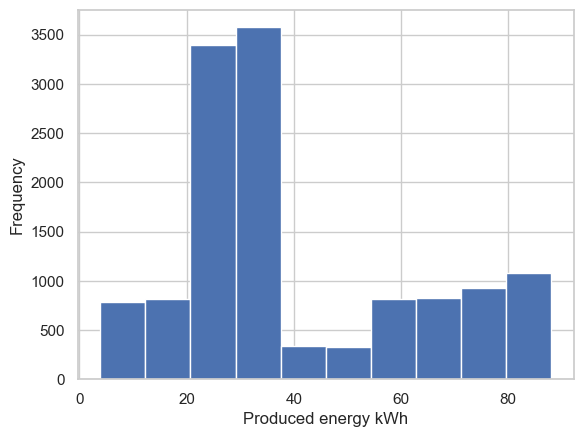

In [362]:
cumulative_production_nan_cleaned[cumulative_production_nan_cleaned[VALUE_KWH] < lower_limit][VALUE_KWH].plot.hist()
plt.xlabel('Produced energy kWh')
plt.show()

In [363]:
outliers_files_number = cumulative_production_nan_cleaned[cumulative_production_nan_cleaned[VALUE_KWH] < lower_limit].groupby(FILENAME).size().size
non_empty_files_number = files_numbers.sum() - empty_files_numbers.sum()
files_with_outliers_percantage = outliers_files_number / non_empty_files_number  * 100
print(f"{outliers_files_number} out of {non_empty_files_number} non-empty files are with outliers in data ({files_with_outliers_percantage:.2f}%).")

85 out of 363 non-empty files are with outliers in data (23.42%).


In [364]:
cumulative_production_outliers_cleaned = cumulative_production_nan_cleaned.drop(cumulative_production_nan_cleaned[cumulative_production_nan_cleaned[VALUE_KWH] < 100].index)

In [365]:
cumulative_production_outliers_cleaned["day"] = pd.DatetimeIndex(cumulative_production_outliers_cleaned["time"]).day.astype(int)

### Production calculation (monthly)

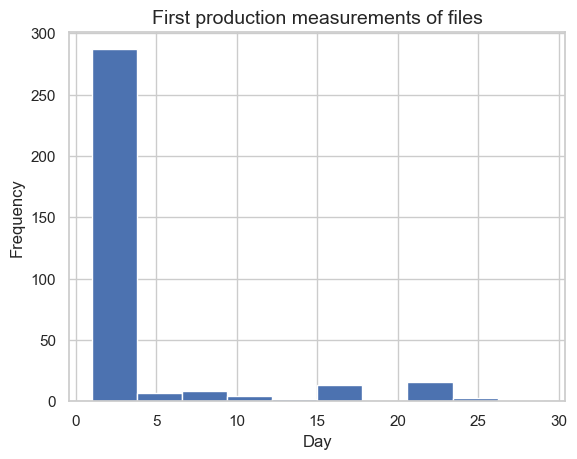

In [366]:
first_measurements_by_month = cumulative_production_outliers_cleaned.groupby(FILENAME).nth(0)
first_measurements_by_month["day"].hist().plot()
plt.title("First production measurements of files", fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [367]:
first_measurements_by_month_filtered = first_measurements_by_month[(first_measurements_by_month["day"] < 5)].reset_index(drop=True)
first_measurements_by_month_filtered

,time,source,value_kwh,filename,year,month,day
0,2021-03-03T15:11:00.124Z,540121820,30975.60,data_540121820_2021-03-01_2021-03-31.csv,2021,3,3
1,2021-04-01T03:46:21.219Z,540121820,32631.16,data_540121820_2021-04-01_2021-04-30.csv,2021,4,1
2,2021-05-01T02:22:07.617Z,540121820,36322.87,data_540121820_2021-05-01_2021-05-31.csv,2021,5,1
3,2021-06-01T01:20:27.599Z,540121820,40483.07,data_540121820_2021-06-01_2021-06-30.csv,2021,6,1
4,2021-07-01T01:15:50.033Z,540121820,46397.46,data_540121820_2021-07-01_2021-07-31.csv,2021,7,1
...,...,...,...,...,...,...,...
285,2022-08-01T02:48:36.378Z,547236080,45552.65,data_547236080_2022-08-01_2022-08-31.csv,2022,8,1
286,2022-09-01T03:28:30.752Z,547236080,48038.76,data_547236080_2022-09-01_2022-09-30.csv,2022,9,1
287,2022-10-01T04:36:05.447Z,547236080,49420.72,data_547236080_2022-10-01_2022-10-31.csv,2022,10,1
288,2022-11-01T06:07:56.363Z,547236080,50028.79,data_547236080_2022-11-01_2022-11-30.csv,2022,11,1


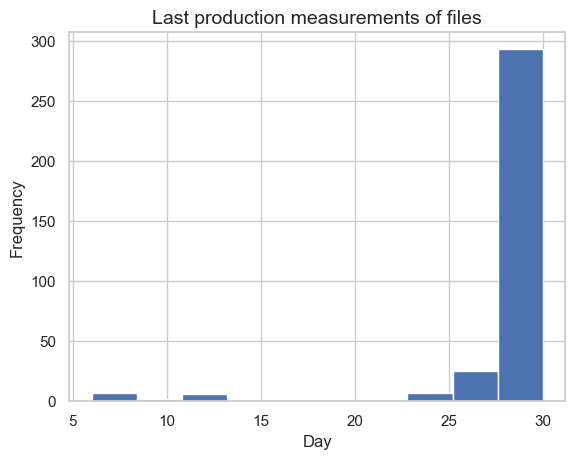

In [368]:
last_measurements_by_month = cumulative_production_outliers_cleaned.groupby(FILENAME).nth(-1)
last_measurements_by_month["day"].hist().plot()
plt.title("Last production measurements of files", fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [369]:
last_measurements_by_month_filtered = last_measurements_by_month[(last_measurements_by_month["day"] > 25)].reset_index(drop=True)
last_measurements_by_month_filtered

,time,source,value_kwh,filename,year,month,day
0,2021-03-30T16:36:20.136Z,540121820,32601.97,data_540121820_2021-03-01_2021-03-31.csv,2021,3,30
1,2021-04-29T17:32:06.604Z,540121820,36233.30,data_540121820_2021-04-01_2021-04-30.csv,2021,4,29
2,2021-05-30T19:05:26.700Z,540121820,40285.84,data_540121820_2021-05-01_2021-05-31.csv,2021,5,30
3,2021-06-29T19:25:49.086Z,540121820,46179.80,data_540121820_2021-06-01_2021-06-30.csv,2021,6,29
4,2021-07-30T18:16:12.001Z,540121820,51995.29,data_540121820_2021-07-01_2021-07-31.csv,2021,7,30
...,...,...,...,...,...,...,...
313,2022-09-29T15:04:56.261Z,547236080,49385.82,data_547236080_2022-09-01_2022-09-30.csv,2022,9,29
314,2022-10-30T14:29:45.664Z,547236080,50005.60,data_547236080_2022-10-01_2022-10-31.csv,2022,10,30
315,2022-11-29T09:23:38.453Z,547236080,50149.06,data_547236080_2022-11-01_2022-11-30.csv,2022,11,29
316,2022-07-29T18:03:29.399Z,547239708,39921.00,data_547239708_2022-07-01_2022-07-31.csv,2022,7,29


In [370]:
def months_consecutive(month, following_month):
    if month == 12 and following_month == 1:
        return True
    elif following_month - month == 1:
        return True
    
    return False

In [371]:
def subtract_monthly_measurements(current_month_value_kwh, next_month_value_kwh, current_month, next_month):
    if months_consecutive(current_month, next_month):
        return next_month_value_kwh - current_month_value_kwh
    return np.nan

subtract_measurements_vectorized  = np.vectorize(subtract_monthly_measurements)

def calculate_montly_production(group):
    values_kwh = group[VALUE_KWH]
    months = group[MONTH]

    monthly_production = subtract_measurements_vectorized(
        values_kwh, 
        values_kwh.shift(-1),
        months, 
        months.shift(-1)
    )

    monthly_production_df = pd.DataFrame(monthly_production, columns=["monthly_production_kwh"])
    return pd.concat([monthly_production_df, months.reset_index(drop=True), group[YEAR].reset_index(drop=True), group[FILENAME].reset_index(drop=True)], axis=1)

In [372]:
monthly_production = first_measurements_by_month_filtered.groupby(SOURCE).apply(calculate_montly_production).reset_index().drop(columns=["level_1"])
monthly_production

,source,monthly_production_kwh,month,year,filename
0,540121820,1655.56,3,2021,data_540121820_2021-03-01_2021-03-31.csv
1,540121820,3691.71,4,2021,data_540121820_2021-04-01_2021-04-30.csv
2,540121820,4160.20,5,2021,data_540121820_2021-05-01_2021-05-31.csv
3,540121820,5914.39,6,2021,data_540121820_2021-06-01_2021-06-30.csv
4,540121820,5766.83,7,2021,data_540121820_2021-07-01_2021-07-31.csv
...,...,...,...,...,...
285,547236080,2486.11,8,2022,data_547236080_2022-08-01_2022-08-31.csv
286,547236080,1381.96,9,2022,data_547236080_2022-09-01_2022-09-30.csv
287,547236080,608.07,10,2022,data_547236080_2022-10-01_2022-10-31.csv
288,547236080,NaN,11,2022,data_547236080_2022-11-01_2022-11-30.csv


In [373]:
nan_indices = monthly_production[monthly_production["monthly_production_kwh"].isna()].index
filenames_to_recalculate = monthly_production.iloc[nan_indices][FILENAME].tolist()

In [374]:
first_measurements_to_merge = first_measurements_by_month_filtered[first_measurements_by_month_filtered[FILENAME].isin(filenames_to_recalculate)]
last_measurements_to_merge = last_measurements_by_month_filtered[last_measurements_by_month_filtered[FILENAME].isin(filenames_to_recalculate)]

measurements_by_month = pd.concat([first_measurements_to_merge, last_measurements_to_merge]).sort_values(by=[FILENAME, "time"]).reset_index(drop=True)
measurements_by_month.head(6)

,time,source,value_kwh,filename,year,month,day
0,2021-08-01T02:21:13.029Z,540121820,52164.29,data_540121820_2021-08-01_2021-08-31.csv,2021,8,1
1,2021-08-30T17:14:55.380Z,540121820,55352.32,data_540121820_2021-08-01_2021-08-31.csv,2021,8,30
2,2021-11-01T05:32:23.272Z,540121820,59671.42,data_540121820_2021-11-01_2021-11-30.csv,2021,11,1
3,2021-11-28T11:38:12.828Z,540121820,60130.22,data_540121820_2021-11-01_2021-11-30.csv,2021,11,28
4,2022-12-01T08:28:49.078Z,540121820,93303.64,data_540121820_2022-12-01_2022-12-31.csv,2022,12,1
5,2021-08-01T02:34:25.956Z,547236018,79453.90,data_547236018_2021-08-01_2021-08-31.csv,2021,8,1


In [375]:
indices_to_drop = measurements_by_month.groupby(FILENAME).filter(lambda group: len(group) < 2).index
measurements_by_month_filtered = measurements_by_month.drop(index=indices_to_drop).reset_index(drop=True)

In [376]:
measurements_by_month_filtered["monthly_production_kwh"] = measurements_by_month_filtered.groupby([SOURCE, FILENAME])[VALUE_KWH].diff(-1) * (-1)
measurements_by_month_filtered = measurements_by_month_filtered.dropna().reset_index(drop=True).drop(columns=["time", "day", VALUE_KWH])
measurements_by_month_filtered.head(6)

,source,filename,year,month,monthly_production_kwh
0,540121820,data_540121820_2021-08-01_2021-08-31.csv,2021,8,3188.03
1,540121820,data_540121820_2021-11-01_2021-11-30.csv,2021,11,458.80
2,547236018,data_547236018_2021-08-01_2021-08-31.csv,2021,8,2996.60
3,547236018,data_547236018_2021-11-01_2021-11-30.csv,2021,11,393.00
4,547236058,data_547236058_2021-01-01_2021-01-31.csv,2021,1,20.22
5,547236058,data_547236058_2021-08-01_2021-08-31.csv,2021,8,2390.54


In [377]:
monthly_production_complete = monthly_production.merge(measurements_by_month_filtered, on=[SOURCE, YEAR, MONTH, FILENAME], how="outer")
monthly_production_complete.head(1)

,source,monthly_production_kwh_x,month,year,filename,monthly_production_kwh_y
0,540121820,1655.56,3,2021,data_540121820_2021-03-01_2021-03-31.csv,NaN


In [378]:
monthly_production_complete

,source,monthly_production_kwh_x,month,year,filename,monthly_production_kwh_y
0,540121820,1655.56,3,2021,data_540121820_2021-03-01_2021-03-31.csv,NaN
1,540121820,3691.71,4,2021,data_540121820_2021-04-01_2021-04-30.csv,NaN
2,540121820,4160.20,5,2021,data_540121820_2021-05-01_2021-05-31.csv,NaN
3,540121820,5914.39,6,2021,data_540121820_2021-06-01_2021-06-30.csv,NaN
4,540121820,5766.83,7,2021,data_540121820_2021-07-01_2021-07-31.csv,NaN
...,...,...,...,...,...,...
285,547236080,2486.11,8,2022,data_547236080_2022-08-01_2022-08-31.csv,NaN
286,547236080,1381.96,9,2022,data_547236080_2022-09-01_2022-09-30.csv,NaN
287,547236080,608.07,10,2022,data_547236080_2022-10-01_2022-10-31.csv,NaN
288,547236080,NaN,11,2022,data_547236080_2022-11-01_2022-11-30.csv,120.27


In [379]:
monthly_production_complete["monthly_production_kwh_x"].fillna(monthly_production_complete["monthly_production_kwh_y"], inplace=True)
monthly_production_complete = monthly_production_complete.drop(columns="monthly_production_kwh_y").dropna(axis=0)
monthly_production_complete.rename(columns={"monthly_production_kwh_x": "monthly_production_kwh"}, inplace=True)
monthly_production_complete

,source,monthly_production_kwh,month,year,filename
0,540121820,1655.56,3,2021,data_540121820_2021-03-01_2021-03-31.csv
1,540121820,3691.71,4,2021,data_540121820_2021-04-01_2021-04-30.csv
2,540121820,4160.20,5,2021,data_540121820_2021-05-01_2021-05-31.csv
3,540121820,5914.39,6,2021,data_540121820_2021-06-01_2021-06-30.csv
4,540121820,5766.83,7,2021,data_540121820_2021-07-01_2021-07-31.csv
...,...,...,...,...,...
284,547236080,2946.33,7,2022,data_547236080_2022-07-01_2022-07-31.csv
285,547236080,2486.11,8,2022,data_547236080_2022-08-01_2022-08-31.csv
286,547236080,1381.96,9,2022,data_547236080_2022-09-01_2022-09-30.csv
287,547236080,608.07,10,2022,data_547236080_2022-10-01_2022-10-31.csv


In [380]:
suitable_files_number = monthly_production_complete.groupby(FILENAME).size().size
suitable_files_percantage = suitable_files_number / non_empty_files_number * 100
print(f"{suitable_files_percantage:.2f}% of non-empty files were used for monthly solar production calculation ({suitable_files_number} files out of {non_empty_files_number}).")

76.58% of non-empty files were used for monthly solar production calculation (278 files out of 363).


In [381]:
buidlings_number = monthly_production_complete.groupby(SOURCE).size().size

In [382]:
buildings_number_full_year_production = monthly_production_complete.groupby([SOURCE, YEAR]).filter(lambda group: len(group) == 12).groupby(SOURCE).size().size
print(f"Number of buildings with solar production calculated for 12 months: {buildings_number_full_year_production}.")

Number of buildings with solar production calculated for 12 months: 0.


In [383]:
buildings_number_10_months_production = monthly_production_complete.groupby([SOURCE, YEAR]).filter(lambda group: len(group) > 10).groupby(SOURCE).size().size
print(f"Number of buildings with solar production calculated at least for 10 months: {buildings_number_10_months_production}.")

Number of buildings with solar production calculated at least for 10 months: 10.


In [384]:
monthly_production_mapped = pd.merge(buildings_df, monthly_production_complete, on=SOURCE, how="right")
monthly_production_mapped.drop(columns=[FILENAME], inplace=True)
monthly_production_mapped.head(5)

,etak_id,source,address,pv_area_m2,monthly_production_kwh,month,year
0,719155,540121820,Tiigi 19,198.98,1655.56,3,2021
1,719155,540121820,Tiigi 19,198.98,3691.71,4,2021
2,719155,540121820,Tiigi 19,198.98,4160.20,5,2021
3,719155,540121820,Tiigi 19,198.98,5914.39,6,2021
4,719155,540121820,Tiigi 19,198.98,5766.83,7,2021


In [385]:
monthly_production_mapped.to_csv("monthly_production_by_building.csv", index=False)

### Production calculation (annual)

In [386]:
month_mean = []
months = range(1, 13)
for month in months:
    month_mean.append(monthly_production_complete[monthly_production_complete[MONTH] == month]["monthly_production_kwh"].mean())

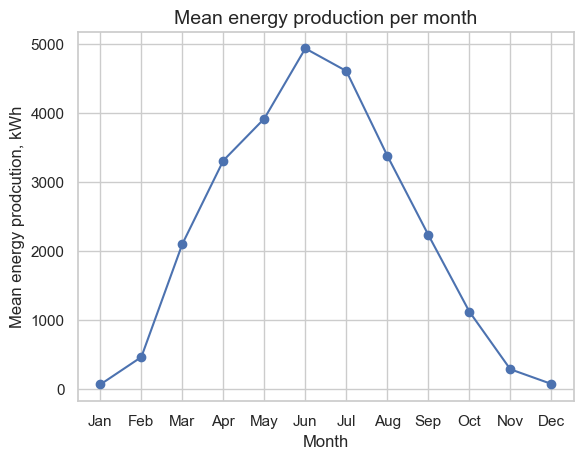

In [390]:
months_abbr = list(calendar.month_abbr)[1:]
plt.plot(months, month_mean, '-o')
plt.xticks(months, months_abbr)
plt.title("Mean energy production per month", fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Mean energy prodcution, kWh', fontsize=12)
plt.grid(True)
plt.show()

In [163]:
first_measurements_by_year = first_measurements_by_month_filtered[first_measurements_by_month_filtered[YEAR] > 2020].groupby([SOURCE, YEAR]).nth(0)
first_measurements_by_year_filtered = first_measurements_by_year[(first_measurements_by_year[MONTH] < 4)].reset_index()
first_measurements_by_year_filtered.head(3)

,source,year,filename,time,value_kwh,month,day
0,540121820,2021,data_540121820_2021-03-01_2021-03-31.csv,2021-03-03T15:11:00.124Z,30975.60,3,3
1,540121820,2022,data_540121820_2022-01-01_2022-01-31.csv,2022-01-04T09:17:31.105Z,60159.28,1,4
2,547236018,2021,data_547236018_2021-01-01_2021-01-31.csv,2021-01-01T08:08:34.528Z,59264.70,1,1


In [164]:
last_measurements_by_year = last_measurements_by_month_filtered[last_measurements_by_month_filtered[YEAR] > 2020].groupby([SOURCE, YEAR]).nth(-1)
last_measurements_by_year_filtered = last_measurements_by_year[(last_measurements_by_year[MONTH] > 9)].reset_index()
last_measurements_by_year_filtered.head(3)


,source,year,filename,time,value_kwh,month,day
0,540121820,2021,data_540121820_2021-12-01_2021-12-31.csv,2021-12-30T10:52:15.620Z,60158.79,12,30
1,540121820,2022,data_540121820_2022-11-01_2022-11-30.csv,2022-11-29T09:22:23.786Z,93303.63,11,29
2,547236018,2021,data_547236018_2021-12-01_2021-12-31.csv,2021-12-30T09:55:52.070Z,86746.20,12,30


In [165]:
def subtract_annual_measurements(current_year_value_kwh, next_year_value_kwh, current_year, next_year):
    if next_year - current_year == 1:
        return next_year_value_kwh - current_year_value_kwh
    return np.nan

subtract_annual_measurements_vectorized  = np.vectorize(subtract_annual_measurements)

In [166]:
def calculate_annual_production(group):
    values_kwh = group[VALUE_KWH]
    years = group[YEAR]

    annual_production = subtract_annual_measurements_vectorized(
        values_kwh, 
        values_kwh.shift(-1),
        years, 
        years.shift(-1)
    )

    annual_production_df = pd.DataFrame(annual_production, columns=[ANNUAL_KWH])
    return pd.concat([annual_production_df, years.reset_index(drop=True)], axis=1)

In [167]:
annual_production = first_measurements_by_year_filtered.groupby(SOURCE).apply(calculate_annual_production).reset_index().drop(columns=["level_1"])
annual_production

,source,annual_kwh,year
0,540121820,29183.68,2021
1,540121820,NaN,2022
2,547236018,27484.60,2021
3,547236018,NaN,2022
4,547236054,NaN,2022
5,547236058,20513.14,2021
6,547236058,NaN,2022
7,547236060,22272.69,2021
8,547236060,NaN,2022
9,547236062,NaN,2022


In [168]:
nan_indices = annual_production[annual_production[ANNUAL_KWH].isna()].index
sources_to_recalculate = annual_production.iloc[nan_indices][SOURCE].tolist()

In [169]:
fisrt_annual_measurements_to_merge = first_measurements_by_year_filtered[first_measurements_by_year_filtered[SOURCE].isin(sources_to_recalculate)]
last_annual_measurements_to_merge = last_measurements_by_year_filtered[last_measurements_by_year_filtered[SOURCE].isin(sources_to_recalculate)]

measurements_by_year = pd.concat([fisrt_annual_measurements_to_merge, last_annual_measurements_to_merge]).sort_values(by=[FILENAME, "time"]).reset_index(drop=True)
indices_to_drop = measurements_by_year.groupby([SOURCE, YEAR]).filter(lambda group: len(group) < 2).index
measurements_by_year_filtered = measurements_by_year.drop(index=indices_to_drop).reset_index(drop=True)

In [170]:
measurements_by_year_filtered[ANNUAL_KWH] = measurements_by_year_filtered.groupby([SOURCE, YEAR])[VALUE_KWH].diff(-1) * (-1)
measurements_by_year_filtered = measurements_by_year_filtered.dropna().reset_index(drop=True).drop(columns=["time", MONTH, "day", VALUE_KWH, FILENAME])
measurements_by_year_filtered

,source,year,annual_kwh
0,540121820,2021,29183.19
1,540121820,2022,33144.35
2,547236018,2021,27481.50
3,547236018,2022,30381.91
4,547236054,2022,23177.16
5,547236058,2021,20511.83
6,547236058,2022,23752.37
7,547236060,2021,22271.64
8,547236060,2022,24780.80
9,547236062,2022,19879.62


In [171]:
annual_production_complete = annual_production.merge(measurements_by_year_filtered, on=[SOURCE, YEAR], how="outer")
annual_production_complete.head(1)

,source,annual_kwh_x,year,annual_kwh_y
0,540121820,29183.68,2021,29183.19


In [172]:
annual_production_complete[ANNUAL_KWH + "_x"].fillna(annual_production_complete[ANNUAL_KWH + "_y"], inplace=True)
annual_production_complete = annual_production_complete.drop(columns=ANNUAL_KWH + "_y").dropna(axis=0)
annual_production_complete.rename(columns={ANNUAL_KWH + "_x": ANNUAL_KWH}, inplace=True)
annual_production_complete

,source,annual_kwh,year
0,540121820,29183.68,2021
1,540121820,33144.35,2022
2,547236018,27484.60,2021
3,547236018,30381.91,2022
4,547236054,23177.16,2022
5,547236058,20513.14,2021
6,547236058,23752.37,2022
7,547236060,22272.69,2021
8,547236060,24780.80,2022
9,547236062,19879.62,2022


In [173]:
annual_production_mapped = pd.merge(buildings_df, annual_production_complete, on=SOURCE, how="right")
annual_production_mapped.head(5)

,etak_id,pv_area_m2,source,address,annual_kwh,year
0,719155,195.82,540121820,Tiigi 19,29183.68,2021
1,719155,195.82,540121820,Tiigi 19,33144.35,2022
2,716647,182.69,547236018,Tähe 2,27484.60,2021
3,716647,182.69,547236018,Tähe 2,30381.91,2022
4,720043,146.65,547236054,Aleksandri 3,23177.16,2022


In [174]:
annual_production_mapped.to_csv("annual_production_by_building.csv", index=False)

In [175]:
annual_production_mapped[annual_production_mapped[YEAR] == 2021].shape[0]

10

In [176]:
annual_production_mapped[annual_production_mapped[YEAR] == 2022].shape[0]

13